## <center>Zillow Clustering Project:<center>_What is Driving Zestimates Errors?_<center>
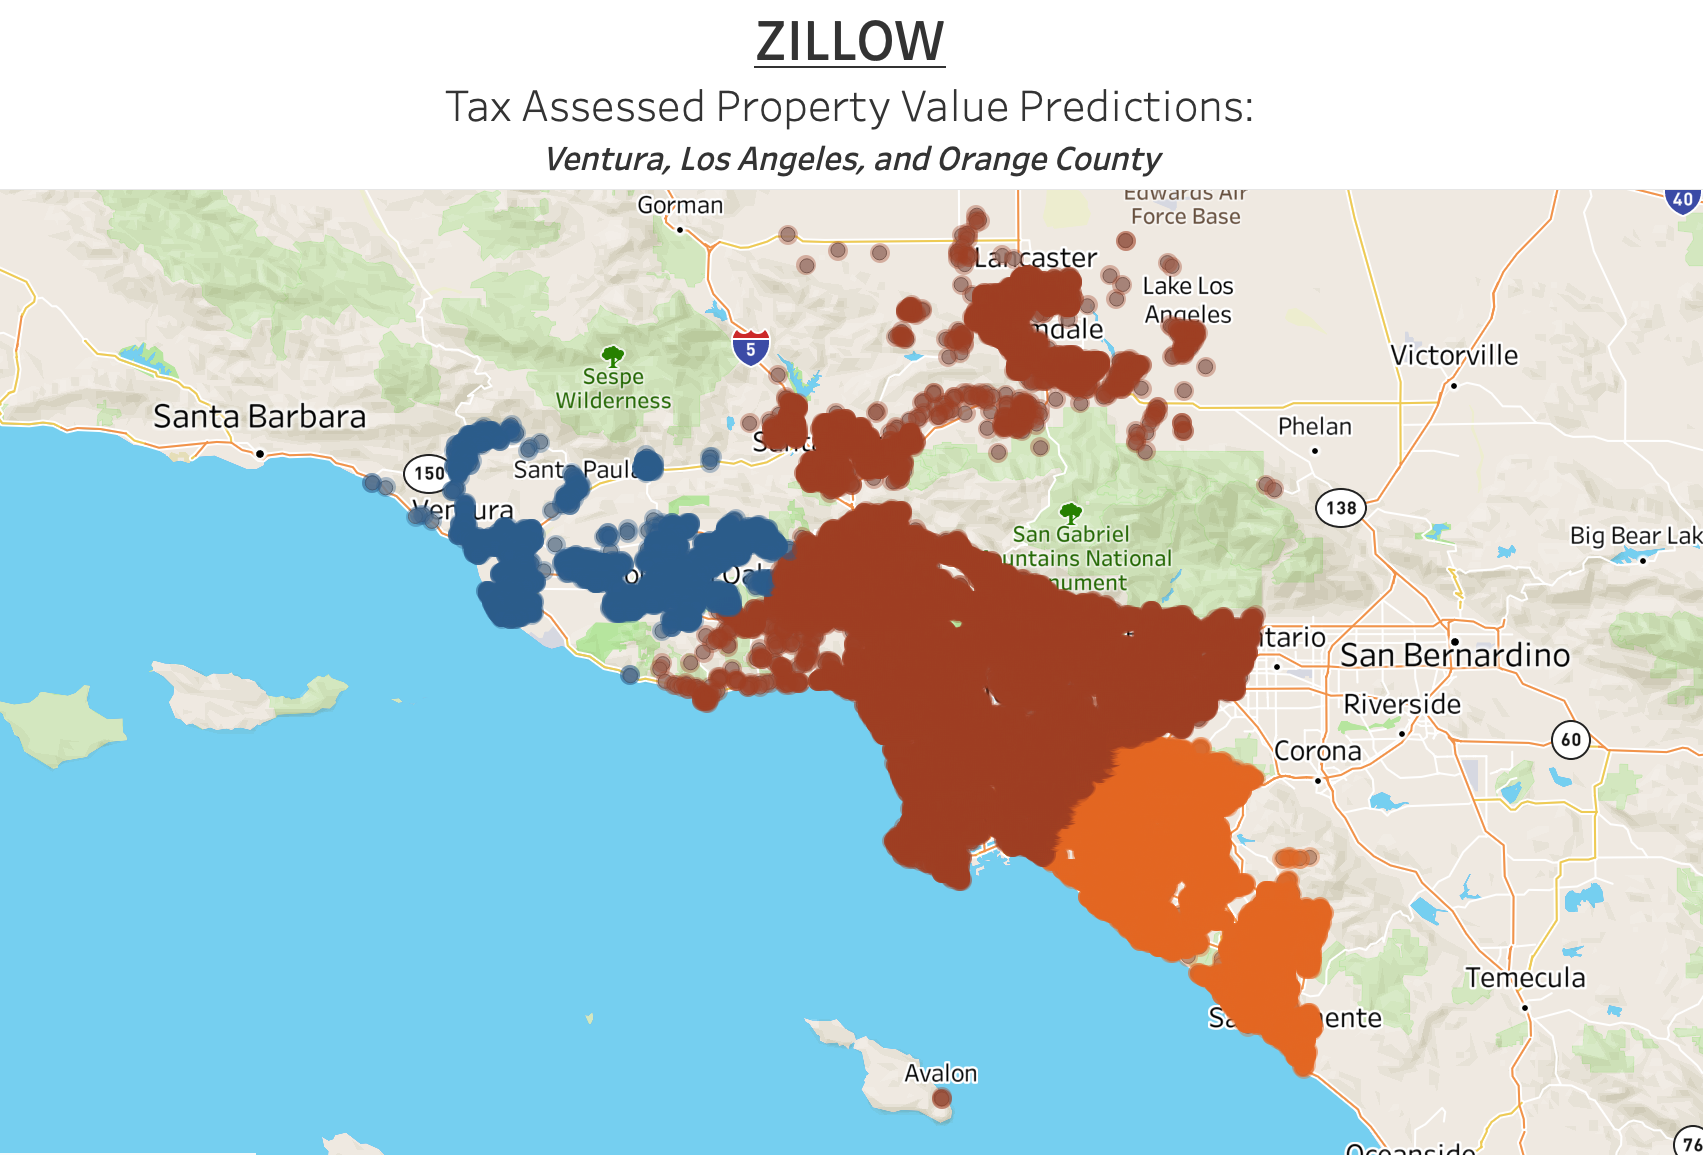
### <center> __Log Error = log(Zestimate) - log(Sale Price)__ <center>

### Project Goals:

- Discover the key drivers of zestimate errors for single family properties.

- Analyze commonalities of zestimates that have overpredicted actual market price (positive value of log error)

- Analyze commonalities of zestimates that have underpredicted actual market price (negative value of log error)
    
- Empower zillow executives with insights which can influence business strategies

- Attempt to increase target variable (log error) predictions utilizing machine learning algorithms at the grassroots level.

- Set a clear and solid foundation for future exploration and modeling

- Thoroughly document the process and key findings.


### Summary of Findings & Recommendations:
-  I have discovered some weak relationships between features (and specific combinations of features) to log error.
-  High positive log error (Zillow overpredicting the home price) & high negative log error (underprediction) have slightly different divers
-  **Higher over prediction risk:**
    - older homes
    - one bedroom homes
    - homes with one or four bathrooms
    - homes with assessed value on the very high or very low end
    - specific locations
- **Higher under prediction risk:**
    - older homes
    - specific locations
- **Best predictions (log error close to zero):**
    - homes built after 1970
    - homes in Orange county and other more specific locations
    - homes with 3 or 4 bedrooms
- I have attempted modeling to predict the target variable (log error) using classification algorithms (binning log error ranges in different categories). Specifically, I've built and trained 3 decision tree models and 3 random forest models on:
    - features from the original dataset the show at least a slight relationship to the target variable
    - manufactured features derived from clustering algorithms (KMEANS, DBSCAN)
    - manufactured features derived from clustering algorithms (KMEANS, DBSCAN) modeled on individual clusters (one of the five clusters is demonstrated in this report)
- Thus Far, I have not created a model that I can confidently recommend for utilization, however I did find that it is likely useful to model on subgroups (ie. the clusters demonstrated in this report) to enhance prediction accuracy.
- Moving forward, I'd like to focus on clustering and modeling with the goal of predicting overpredictions vs. underpredictions
- I strongly believe there are unknown features influencing log error and I am requesting further time and resources(additional data) to explore this notion.
- I recommend gathering additional data:
    - revisit features with too much missing data to be useful (ie. air conditioning type, heating type, basements) and attempting to gather missing information
    - obtain data that is not currently part of zillow's dataset:
    - population demographics
    - school districts
    - previous transaction history
    - proximity to the coast, schools, churches, airports, landmarks, jails, etc.
    - information on renovations

### Data Acquisition & Preparation
- Import necessary libraries
- Import user defined functions (acquire.py, prepare.py)
- Data imported meets the following conditions:
    > - Single family homes in Orange county, CA, Ventura, CA, or Los Angeles, CA
    > - Had a transaction in 2017
    > - Data available in zillow properties_2017 table

In [1]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import prepare
import explore

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import sklearn.preprocessing
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.cluster.vq import kmeans2, whiten

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

np.random.seed(123)

In [2]:
df = acquire.get_zillow_data()
# this is a user-defined function in acquire.py that pulls in selected data from the SQL database

In [3]:
df.info()
# gives an overview of the imported data including number of records, column names, number of non-null records, and datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   storytypeid                   47 non-null     float64
 2   heatingorsystemtypeid         33935 non-null  float64
 3   airconditioningtypeid         13638 non-null  float64
 4   architecturalstyletypeid      70 non-null     float64
 5   parcelid                      52441 non-null  int64  
 6   id                            52441 non-null  int64  
 7   basementsqft                  47 non-null     float64
 8   bathroomcnt                   52441 non-null  float64
 9   bedroomcnt                    52441 non-null  float64
 10  buildingclasstypeid           0 non-null      object 
 11  buildingqualitytypeid         33740 non-null  float64
 12  calculatedbathnbr             52304 non-null  float64
 13  d

### Handling Null (missing) Values:

- Approximately half of the columns have a significant amount(over 50%) null/missing values

- I am dropping columns with:
    > - over 50% null/missing records
    > - redundant data/duplicate columns
    > - incorrect information (regionidzip values are incorrect as they are not in California)
    > - unknown or unuseful data at this time (ie. censustractandblock - I will need to gather further information before utilizing this column)
    > - pool and garage information: because there is already a '0' value in these columns and because there are so many nulls in this dataset in "extras-type" columns, I do not think it is wise to assume all(or even most) of these nulls can be accurately filled with 0s. 

- For the remaining columns, I am dropping records with null values as this is only ~1% of the dataframe

### Removing Outliers & Improving Prediction Capabilities:

##### The following limitations have been implemented to maximize prediction efforts:

   > - Number of bathrooms between 1 and 5 (column name: bathrooms)
   > - Number of bedrooms range between 1 and 5 (column name: bedrooms)
   > - Tax assessed property value between 40k - 3m (column name: taxvaluedollarcnt)
   > - Year built from 1910 on (column name: year_built)
   > - Property size greater than 650 and less than 5,500 square feet (column: square_feet)
   > - Log error between -0.31 and 0.5 (column name: log_error)

In [4]:
df = prepare.remove_outliers(df)
# this pre-defined user function reduces the number of outliers in features.
df = prepare.handle_nulls(df)
# this pre-defined user function handles nulls by either dropping the column, replacing the null value, or dropping records in the dataframe where a null value is present
df = prepare.rename_columns(df)
# this pre-defined user function renames columns based on what I consider to be descriptive, but easy to work with. Names are switched to snake case as a personal preference.
df = prepare.prepare_locs(df)
# this pre-defined user function reformats the latitude and longitude data in correct form.

### Univariate Exploration

- Explore and visualize the data independently 
- The goal of this step is to get to know the data well

### Visualization of target variable (log error) distribution

Text(0.5, 1.0, 'Log Error Distribution')

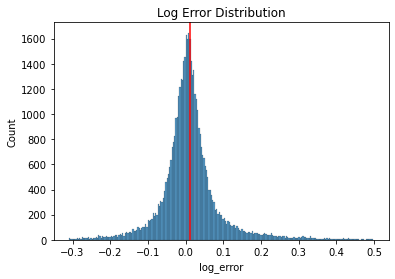

In [5]:
sns.histplot(data= df.log_error)
#creates a histogram to show the distribution of the variable
plt.axvline(x= df.log_error.mean(), color='r', label='axvline - full height')
#sets parameters including a line on the center point of the distribution
plt.title('Log Error Distribution')


#### Takeaways from target variable (log error) distribution graph:

Log error seems to be pretty evenly distributed, but since the value range is so small and there is a slight skew in the positive log error direction, I will analyze negative log error and positive log error (under prediction and over prediction) separately in this report
    

In [6]:
continuous = df[['year_built', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'bedrooms', 'bathrooms', 'square_feet', 'lot_size','propertycountylandusecode' ]]

<Figure size 432x288 with 0 Axes>

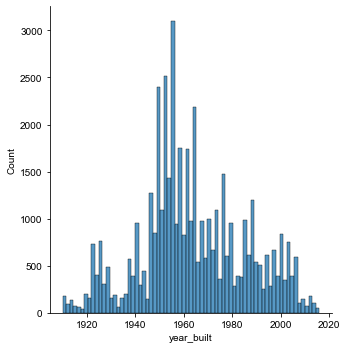

<Figure size 432x288 with 0 Axes>

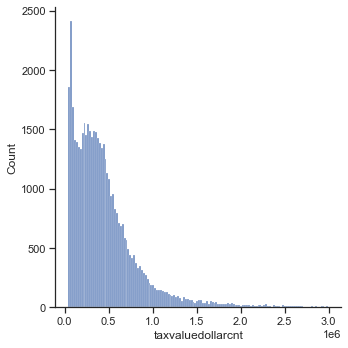

<Figure size 432x288 with 0 Axes>

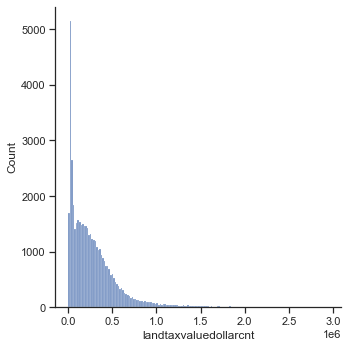

<Figure size 432x288 with 0 Axes>

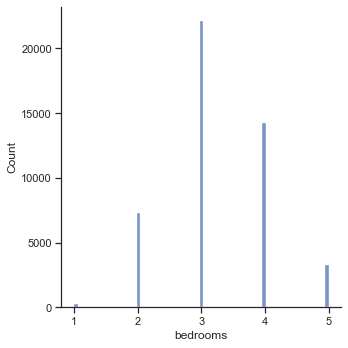

<Figure size 432x288 with 0 Axes>

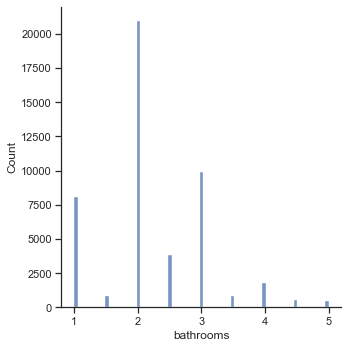

<Figure size 432x288 with 0 Axes>

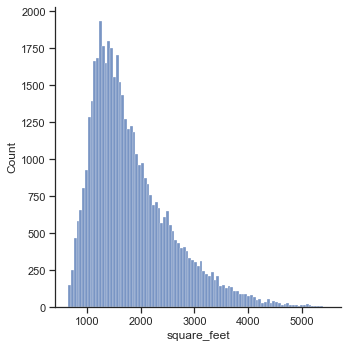

<Figure size 432x288 with 0 Axes>

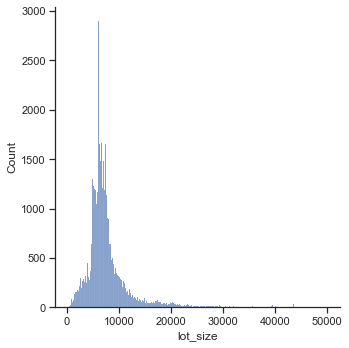

<Figure size 432x288 with 0 Axes>

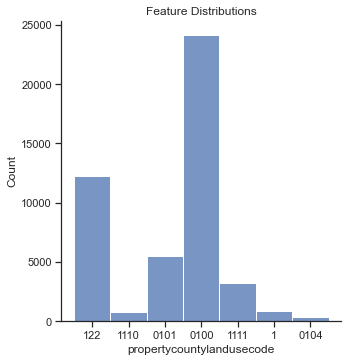

In [7]:
for column in continuous.columns:
    plt.figure()           
    sns.displot(df[column])
    sns.set(style="ticks")
  # column is chosen here
plt.title('Feature Distributions')
plt.show()

### Takeaways from target variable (log error) distribution graph:

The most common feature values are:

- Properties having 3 bedrooms and 2 bathrooms is most common
- Properties built around 1950 and later
- Properties valued at less than $800,000 
- Properties less than ~3000 square feet & ~10,000 lot size square feet
- Properties in LA county with a land use code of 0100


### Exploratory Data Analysis & Statistical Testing

- Create hypotheses regarding drivers of log error.
- Split data into 3 subsets for proper statistical analysis and modeling.
- Use the train data to explore hypotheses.
- Visualize bivariate and/or multivariate data and assess hypotheses using statistical tests.
- Create meaningful clusters using KMEANS and DBSCAN clustering algorithms

### Hypotheses & Exploration Plan:

- Do different features drive decreased negative log error (underpredicting) verses increased positive(over predicting)?
    - Separate train dataframe into negative and positive (**note: this  is for exploratory purposes on train only. For predictive modeling, we do not know if log error will be positive or negative so I will only be splitting train data**)

- What kind of relationship does year built have to log error (if any)? I predict that older homes would be harder to predict, but I am curious to see if they'd be over predicted or under.

- Are there features that share some similarities and could be combined into a new feature to aid in predicting?

### Splitting Data
Splitting data into 3 subsets (train, validate, test) for proper statistical analysis, exploration, modeling, and assessment.
- Train: explore features and relationships to target variable, statistical analysis, build models 
- Validate: evaluate model performance compared to the train dataset, Assess potential overfitting
- Test: run only the chosen top performing to ensure model performs as expected on unseen data before employing

In [8]:
train, validate, test = prepare.split_zillow_data(df)

# Splits data into 3 subsets: train, validate, test. Random state specifying that data is split
# with the exact same records when the code is re-run (useful for exploration and modeling, yet
# I suggest dropping this when employing the model)

train.shape, validate.shape, test.shape

((26423, 16), (11325, 16), (9437, 16))

### First Question

- Do different features drive decreased negative log error (underpredicting) than increased positive(over predicting)?
    - Separate train dataframe into negative and positive (**note: this splitting is for exploratory purposes on train only. For predictive modeling, we do not know if log error will be positive or negative so I will only be splitting train data**)
    - Create log error bins & bins with features to more easily assess potential relationships
    - Graph the bivariate relationships of features to log error bins
    - Summarize findings

In [9]:
train_neg = train.where(train.log_error < 0).dropna()
train_pos = train.where(train.log_error > 0).dropna()
#creates two separate dataframes for positive and negative

In [10]:
train_neg.log_error.mean(), train_pos.log_error.mean()
#returns negative and positive log_error means respectively

(-0.04627954605175586, 0.057585161740826056)

#### I will use the log error means to specify 4 categories(bins) of log_errors:
    
   - **high_neg** : under prediction greater than the average under prediction. This can be considered a "bad prediction"
   - **low_neg** :  under prediction, but lower than average under prediction. This can be considered a "good prediction"
   - **low_pos** : over prediction, but lower than average over prediction, This can be considered a "good prediction"
   - **high_pos**: over prediction greater than the average over prediction. This can be considered a "bad prediction"

In [11]:
prepare.make_zillow_bins(train, validate, test, train_pos, train_neg)
# this pre-defined user function creates bins on features in all datasets.

### Bivariate Visualization
- Bar charts depicting each feature's relationship (or lack thereof) with log error

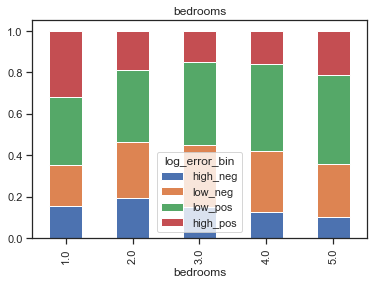

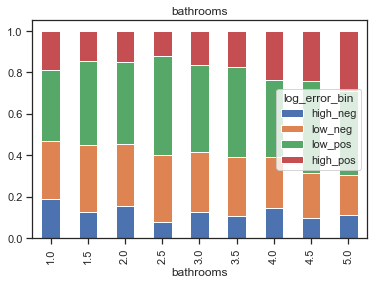

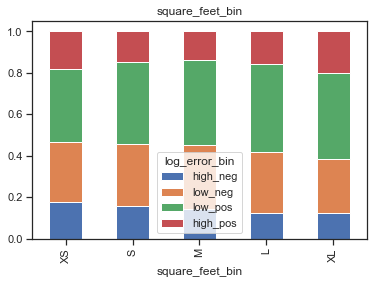

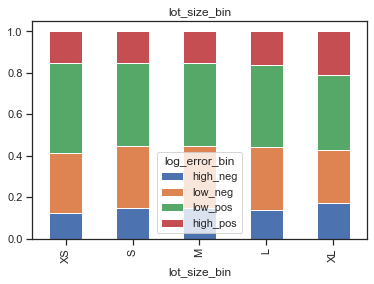

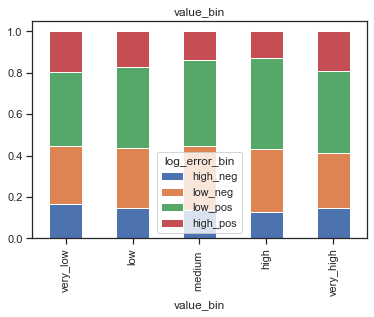

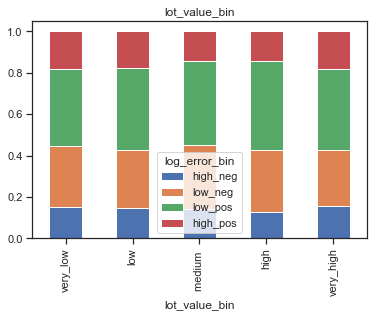

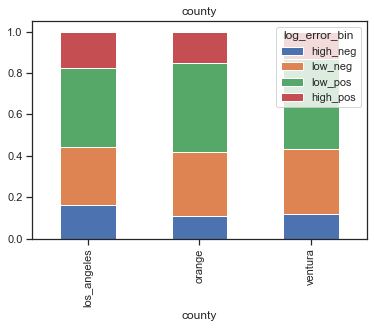

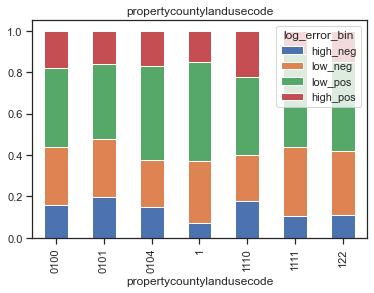

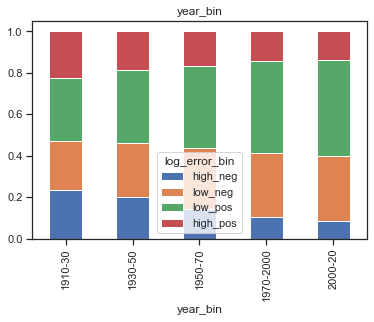

In [12]:
cat_bins = ['bedrooms', 'bathrooms', 'square_feet_bin', 'lot_size_bin', 'value_bin', 'lot_value_bin', 'county', 'propertycountylandusecode', 'year_bin']

# sets parameters of graphs

for i, item in enumerate(cat_bins): 
    
    ax = pd.crosstab(train[item],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
    ax.set_title(item)


Takeaways from categorial bin graphs:
    
  - **Bedrooms:** Homes with one bedroom have the highest risk for being over predicted and interestingly, homes with 2 bedrooms have the highest risk for being under predicted. Homes with 3 or 4 bedrooms tend to have the best predictions.
  - **Bathrooms:** Homes with one or 4+ bathrooms have more over predictions. Under predictions vary quite a bit in all bathroom values, but one bathroom stands out at the most under predictions.
  - **(scat w/hue)Square Feet:** Interestingly, there doesn't appear to be much of a relationship here. Perhaps square feet needs to be combined with another feature/features. I will keep this in mind for the next step.
  - **Lot Size:** Similarly to square feet, I was expecting more of a relationship here. By itself, this feature does not appear to be meaningful predicting lof error.
  - **Tax Assessed Value:** Homes falling on the very high or very low end tend to have a slight increase in high positive log error (over prediction). Under predictions are pretty constant in all value bins.
  - **Tax Assessed Lot Value:** Lot value alone does not seem to be valuable in predicting log error. Predictions look very consistent in all bins.
  - **County:** Homes in Orange county seem to be slightly predicted with more accuracy (lower error on both ends). 
  - **Property Land Use Codes:** These subgroupings in counties do show a much greater variance in prediction capabilities. This may indicate the importance of more fine tuned location data as an important feature.
  - **Year Built:** The relationship here is interesting as the older the home is, the greater the errors seem to be on both the over and under prediction ends. Homes built after 1970 seem to be predicted very well.
    

### Second Question

- What kind of relationship does year built have to log error (if any)? I predict that older homes would be harder to predict, but I am curious to see if they'd be over predicted or under.

As year built showed an interesting relationship with log error graphically, let's further analyze this through statistical testing. I am using a Chi Squared test to explore a potential relationship to homes built before vs. after 1970 to high low error and low log error (on the negative or positive side)

In [13]:
train_high_error = train[(train['log_error_bin'] == 'high_neg') | (train['log_error_bin'] == 'high_pos')]
train_low_error = train[(train['log_error_bin'] == 'low_neg') | (train['log_error_bin'] == 'low_pos')]
train_before1970 = train[(train['year_built'] < 1970)] 
train_1970up = train[(train['year_built'] >= 1970)]
#creates 4 subsets in preparation for cross tabulation 

index = [len(train_high_error), len(train_low_error)]
columns = [len(train_before1970), len(train_1970up)]
# creates indices and columns in preparation for contingency test
index, columns
# returns data for cross tabulation 

([8188, 18235], [16966, 9457])

**Setting Alpha:** Alpha is set to an industry standard of .05 which will be the threshold in determine statistical significance  

$H_0$: high/low log error and pre/post 1970 homes are independent of each other 

$H_a$ : There is relationship between high/low log error and pre/post 1970 homes

In [14]:
alpha = .05 #sets alpha at an industry standard which is used to determine statistical significance
observed = pd.DataFrame([[8188, 18235], [16966, 9457]], index=index, columns=columns)
#creates a cross tabulation dataframe 
chi2, p, degf, expected = stats.chi2_contingency(observed)
# assigns variable names to statistically relevant data in the chi test

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p > alpha:
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis. There is a likely relationship between a high/low log error and pre/post 1970 homes.")
# prints the results of the statistical test

chi^2 = 5844.4404
p     = 0.0000
We reject the null hypothesis. There is a likely relationship between a high/low log error and pre/post 1970 homes.


**Summary of statistical analysis of year built in relation to log error:**

Based on this chi squared test, I can determine a likely relationship here. This relationship is vague for the time being as I created boolean arguments to give a very big picture of where I can potentially start a deeper dive.

### Third Question:

- Are there features that share some similarities and could be combined into a new feature to aid in predicting? 

Because year built shows a vague, but decent relationship with log error, I am revisiting square footage to see if there is a relationship between this and year built. If so, I could potentially group these 2 variables together in a meaningful way that may provide more insight about log error drivers. First, let's see if these variables are likely correlated by utilizing statistical testing.

$H_0$: There is no correlation between year built to square footage.

$H_a$ : There is a correlation between year built to square footage.

In [15]:
alpha = .05
x = train.square_feet
y = train.year_built
# creates short variable assignments

corr, p = stats.pearsonr(x, y)
# creates variables for the r value and the p value respectively

if p > alpha:
    print("We fail to reject the null hypothesis")
elif corr < .4: # sets r value minimum 
    print("We fail to reject the null hypothesis")
else:
    print("We reject the null hypothesis")
    
#pearsonr test that returns correlation strength (r value) and p value 
# (must be less than alpha to reject the null hypothesis)
corr, p

We reject the null hypothesis


(0.4878104343239271, 0.0)

**There is indeed a correlation present here. I will utilize KMEANS clustering to create a derived feature 

In [16]:
explore.create_yearsize_feature(train, train_pos, train_neg, validate, test)
#this pre-defined function takes in the 3 train dataframe as well as validate and test, 
# scales year_built and square_feet using the MinMaxScaler, and creates
# five clusters using a KMEANS clustering algorithm (unsupervised maching learning technique)

### Visualize the new feature dervied from KMEANS clustering

Text(0.5, 1.0, 'Square Footage Correlation to Year Built: Under the Lense of Clusters')

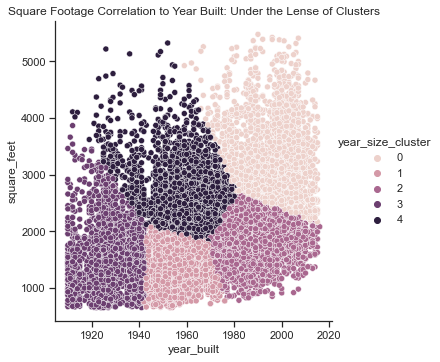

In [17]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.relplot(x='year_built', y='square_feet', data=train, hue='year_size_cluster')#scatter=True, , col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation to Year Built: Under the Lense of Clusters")
# plots the correlation of the two variables on a scatter plot under the lens of the new clusters

**We can certainly see how these clusters were formed by viewing this graphically. I will now rename these clusters in a more meaningful way**

In [18]:
train['year_size_cluster_cat'] = train['year_size_cluster'].replace({0 : '1920-80/med_large', 1: 'prior1940/small_med', 2 : '1940-70/small', 3: 'prior1970/small_med', 4:'1970-pres/med_large'})
validate['year_size_cluster_cat'] = validate['year_size_cluster'].replace({0 : '1920-80/med_large', 1: 'prior1940/small_med', 2 : '1940-70/small', 3: 'prior1970/small_med', 4:'1970-pres/med_large'})
test['year_size_cluster_cat'] = test['year_size_cluster'].replace({0 : '1920-80/med_large', 1: 'prior1940/small_med', 2 : '1940-70/small', 3: 'prior1970/small_med', 4:'1970-pres/med_large'})
#renames clusters in a new column that briefly describes the nature of the cluster

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1920-80/med_large'),
  Text(1, 0, '1940-70/small'),
  Text(2, 0, '1970-pres/med_large'),
  Text(3, 0, 'prior1940/small_med'),
  Text(4, 0, 'prior1970/small_med')])

<Figure size 1080x720 with 0 Axes>

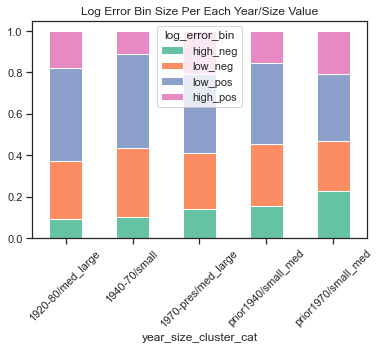

In [19]:
plt.figure(figsize=(15, 10))
pd.crosstab(train['year_size_cluster_cat'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.title('Log Error Bin Size Per Each Year/Size Value')
plt.xticks(rotation=45)
#this visualizes the amount of homes falling in each log error bin per the new year/size feature

### Takeaways from new year/size feature:

interestingly, homes built after 1970 that are smaller are predicted with more accuracy than homes built after 1970 that are on the bigger side. Homes on the bigger side, even 1970 + homes, seem to be over predicted. This derived feature gives further insight into what is driving log error and does indeed make usage of the square footage variable.

In [20]:
explore.create_loc_feature(train, validate, test)
# pre-defined user function that takes in train, validate, test dataframes
# to create a new feature feature with DBSCAN utilized latitude and longitude
# as well as the year/size feature

Text(0.5, 1.0, 'Distribution of log_error_bin values per New Loc Feature')

<Figure size 1080x720 with 0 Axes>

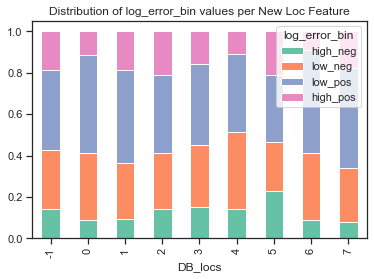

In [21]:
plt.figure(figsize=(15, 10))
pd.crosstab(train['DB_locs'],train['log_error_bin'], 
             normalize='index').plot.bar(stacked=True)
plt.title('Distribution of log_error_bin values per New Loc Feature')
#Graphically shows the distribution log_error_bin numbers for
# each of the values in the new location feature

### Modeling

- Because the relationships of features to log error that I've discovered thus far are underwhelming, I will further simplify the target variable to "high_error" (below the negative mean and above the positive mean- further from 0) and "low_error" (above the negative mean and below the positive mean- closer to 0).
- The goal of this modeling is to utilize classification algorithms on original data, cluster-based features, and lastly model on a cluster-based feature to attempt to analyze (and ideally maximize) predictive potential.

In [22]:
train.log_error_bin.value_counts()

low_pos     10561
low_neg     7674 
high_pos    4364 
high_neg    3824 
Name: log_error_bin, dtype: int64

In [23]:
train['log_error_bin'] = train['log_error_bin'].replace({'high_neg' : 'high_error', 'high_pos': 'high_error', 'low_neg': 'low_error', 'low_pos': 'low_error'})
validate['log_error_bin'] = validate['log_error_bin'].replace({'high_neg' : 'high_error', 'high_pos': 'high_error', 'low_neg': 'low_error', 'low_pos': 'low_error'})
test['log_error_bin'] = test['log_error_bin'].replace({'high_neg' : 'high_error', 'high_pos': 'high_error', 'low_neg': 'low_error', 'low_pos': 'low_error'})
# refines the error bins (target variable) with "high" or "low" error

### Decision Tree and Random Forest Classification on original features

In [24]:
X_train = train[['bedrooms', 'bathrooms', 'square_feet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'year_built', 'lot_size', 'propertycountylandusecode']]
y_train = train[['log_error_bin']]

X_validate = validate[['bedrooms', 'bathrooms', 'square_feet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'year_built', 'lot_size', 'propertycountylandusecode']]
y_validate = validate[['log_error_bin']]

X_test = test[['bedrooms', 'bathrooms', 'square_feet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'year_built', 'lot_size', 'propertycountylandusecode']]
y_test = test[['log_error_bin']]

#creates X and y variables in preparation for modeling

#### Establishing baseline Accuracy
Baseline accuracy will be the sum of the most frequently occuring y outcome(mode) over the length of y. Without modeling, this is the chance that the target will have the value of the mode.

In [25]:
(y_train == 'low_error').sum()/len(y_train) #calculates the baseline accuracy

log_error_bin    0.690118
dtype: float64

In [26]:
clf = DecisionTreeClassifier(max_depth=3) #creates model
clf = clf.fit(X_train, y_train) #fits model

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123) #creates model

rf.fit(X_train, y_train)#fits model

print('Baseline Accuracy: {:}'
      .format(round((y_train == 'low_error').sum()/(len(y_train)),2)))
print('Decision Tree Accuracy')
print('-------------------------------------------')
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))
print('-------------------------------------------')
print('*Random Forest Accuracy*')
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Baseline Accuracy: log_error_bin    0.69
dtype: float64
Decision Tree Accuracy
-------------------------------------------
Accuracy of Decision Tree classifier on training set: 0.69
Accuracy of Decision Tree classifier on validate set: 0.69
-------------------------------------------
*Random Forest Accuracy*
Accuracy of random forest classifier on training set: 0.69
Accuracy of random forest classifier on validate set: 0.69


### Decision Tree and Random Forest Classification using:
**Both derived features, bedrooms, bathrooms, and property county code**

In [27]:
X_train = train[['bedrooms', 'bathrooms', 'propertycountylandusecode', 'DB_locs', 'year_size_cluster']]
y_train = train[['log_error_bin']]

X_validate = validate[['bedrooms', 'bathrooms', 'propertycountylandusecode', 'DB_locs', 'year_size_cluster']]
y_validate = validate[['log_error_bin']]

X_test = test[['bedrooms', 'bathrooms', 'propertycountylandusecode', 'DB_locs', 'year_size_cluster']]
y_test = test[['log_error_bin']]
#creates dataframe with specified features

In [28]:
clf = DecisionTreeClassifier(max_depth=3) #creates model
clf = clf.fit(X_train, y_train) #fits model

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123) #creates model

rf.fit(X_train, y_train)#fits model

print('Baseline Accuracy: {:}'
      .format(round((y_train == 'low_error').sum()/(len(y_train)),2)))
print('Decision Tree Accuracy')
print('-------------------------------------------')
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))
print('-------------------------------------------')
print('*Random Forest Accuracy*')
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Baseline Accuracy: log_error_bin    0.69
dtype: float64
Decision Tree Accuracy
-------------------------------------------
Accuracy of Decision Tree classifier on training set: 0.69
Accuracy of Decision Tree classifier on validate set: 0.69
-------------------------------------------
*Random Forest Accuracy*
Accuracy of random forest classifier on training set: 0.69
Accuracy of random forest classifier on validate set: 0.69


### Decision Tree and Random Forest Classification:
**Modeling on the derived year_size feature using derived features, rooms counts, and property county codes**

In [29]:
train.year_size_cluster_cat.value_counts()
#returns counts of value options in the year_size column

prior1940/small_med    10649
1940-70/small          5218 
1970-pres/med_large    4101 
prior1970/small_med    3433 
1920-80/med_large      3022 
Name: year_size_cluster_cat, dtype: int64

#### Choosing a subgroup for modeling:
- It will be necessary to model on each of these subgroups prior to potential utilization, but for the sake of assessing the potential value of modeling on subgroups, I will choose the '1940-70/small' subgroup as the value counts for this subgroup are somewhat in the middle

In [30]:
train = train[train.year_size_cluster_cat == '1940-70/small']
validate = validate[validate.year_size_cluster_cat == '1940-70/small']
test = test[test.year_size_cluster_cat == '1940-70/small']
#Reassigns train, validate, and test variables to only include one of the five year/size groups 

In [31]:
train.shape, validate.shape, test.shape #displays the number of records that will be used in modeling

((5218, 25), (2271, 25), (1832, 25))

In [32]:
X_train = train[['bedrooms', 'bathrooms', 'propertycountylandusecode', 'DB_locs']]
y_train = train[['log_error_bin']]

X_validate = validate[['bedrooms', 'bathrooms', 'propertycountylandusecode', 'DB_locs']]
y_validate = validate[['log_error_bin']]

X_test = test[['bedrooms', 'bathrooms', 'propertycountylandusecode', 'DB_locs']]
y_test = test[['log_error_bin']]
#reassigns X and y variables with the data belonging to the above subgroup

In [33]:
(y_train == 'low_error').sum()/len(y_train) #calculates the baseline accuracy

log_error_bin    0.790149
dtype: float64

In [34]:
clf = DecisionTreeClassifier(max_depth=3) #creates model
clf = clf.fit(X_train, y_train) #fits model

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123) #creates model

rf.fit(X_train, y_train)#fits model

print('Baseline Accuracy: {:}'
      .format(round((y_train == 'low_error').sum()/(len(y_train)),2)))
print('Decision Tree Accuracy')
print('-------------------------------------------')
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))
print('-------------------------------------------')
print('*Random Forest Accuracy*')
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Baseline Accuracy: log_error_bin    0.79
dtype: float64
Decision Tree Accuracy
-------------------------------------------
Accuracy of Decision Tree classifier on training set: 0.79
Accuracy of Decision Tree classifier on validate set: 0.79
-------------------------------------------
*Random Forest Accuracy*
Accuracy of random forest classifier on training set: 0.79
Accuracy of random forest classifier on validate set: 0.79


### Summary of Modeling:
- For transparency, it's necessary to mention that I did try out classification models on all 5 year_size cluster labels and results were mixed from accuracy being the same as on the full train and validate data sets up to a 10% increase as in this example.
- What this shows is that this model is not ready to be employed at this time, but there is potential here and fine tuning these clusters (perhaps experimenting with other feature relationships), may be possible.
- Because I am confident in my decision to hold off on employing this model, I will not use the test data as no model is selected here.
- Also, ideally I can use some insights gained here about what causes under predicting vs. over predicting to build a model that will not only predict whether or not a home zestimate will have a low or high error, but also tell us if that error will be an under prediction or lower prediction.
- Right now, it's much easier to see what drives errors when looking log error as an absolute value, but I do think continuing to explore details of specifically what drives over and under predictions will be worthwhile and may eventually lead to enhanced zestimate capabilities. I am not there today, but this is the long term goal.

### Conclusion:
- High positive log error (Zillow over predicting the home price) & high negative log error (underprediction) have slightly different drivers
- Higher over prediction risk:
    - older homes
    - one bedroom homes
    - homes with one or four bathrooms
    - homes with assessed value on the very high or very low end
    - specific locations
- Higher under prediction risk:
    - older homes
    - specific locations
- Best predictions (log error close to zero):
    - homes built after 1970
    - homes in Orange county and other more specific locations
    - homes with 3 or 4 bedrooms
**It is important to specify that I consider these relationships to be somewhat weak at this and much more thoroughly/lengthy analysis will be required to potentially arrive at more certainly**

- Thus Far, I have not created a model that I can confidently recommend for utilization, however I did find that it is likely useful to model on subgroups (ie. the clusters demonstrated in this report) to enhance prediction accuracy.

### Next Steps:
- I believe it will be very valuable to dive more into what is causing zestimates to be over predictions versus under predictions. Moving forward, I'd like to focus on clustering and modeling with this goal in mind.
- I strongly believe there are unknown features influencing log error and I am requesting further time and resources(additional data) to explore this notion.
- I recommend gathering additional data:
    - revisit features with too much missing data to be useful (ie. airconditioning type, heating type, basements) and attempting to gather missing information
    - obtain data that is not currently part of zillow's dataset:
        - > population demographics
        - > school districts
        - > previous transaction history
        - > proximity to the coast, schools, churches, airports, landmarks, jails, etc.
        - > information on renovations

**Thank you for your time! Please don't hesitate to reach out for any additional insights I may be able to provide.**



### Summary of Modeling:

- For transparcey, it's necessary to mention that I did try out classification models on all 5 year_size cluster labels and results were mixed from accuracy being the same as on the full train and validate datasets up to a 10% increase as in this example. 

- What this shows is that this model is not ready to be employed at this time, but there is potential here and fine tuning these clusters (perhaps experimenting with other feature relationships), may be possible. 

- Because I am confident in my decision to hold off on employing this model, I am will not use the test data as no model is selected here.

- Also, ideally I can use some insights gained here about what causes under predicting vs. over predicting to build a model that will not only predict whether or not a home zestimate will have a low or high error, but also tell us if that error will be an under prediction or lower prediction. 

- Right now, it's much easier to see what drives errors when looking log error as an absolute value, but I do think continuing to explore details of specifically what drives over and under predictions will be worthwhile and may eventually lead to enhanced zestimate capabilites. I am not there today, but this is the longterm goal.  

### Conclusion:

- High positive log error (Zillow over predicing the home price) & high negative log error (underprediction) have slightly different drivers

- Higher over prediction risk: 
    > - older homes
    > - one bedroom homes 
    > - homes with one or four bathrooms
    > - homes with assessed value on the very high or very low end
    > - specific locations

- Higher under prediction risk:
    > - older homes
    > - specific locations

- Best predictions (log error close to zero):
    > - homes built after 1970 
    > - homes in Orange county and other more specific locations
    > - homes with 3 or 4 bedrooms
    
**It is important to specify that I consider these relationships to be somewhat weak at this and much more thoroughly/lengthy analysis will be required to potentially arrive at more certainly**

- Thusfar, I have not created a model that I can confidentally recommend for utilization, however I did find that it is likely useful to model on subgroups (ie. the clusters demonstrated in this report) to enhance prediction accuracy.


### Next Steps: 

- I believe it will be very valuable to dive more into what is causing zestimates to be over predictions verses under predictions. Moving forward, I'd like to focus on clustering and modeling with this goal in mind.

- I strongly believe there are unknown features influencing log error and I am requesting further time and resources(additional data) to explore this notion.

- I recommend gathering additional data:
    - revisit features with too much missing data to be useful (ie. airconditioning type, heating type, basements) and attempting to gather missing information 
    - obtain data that is not currently part of zillow's dataset:
        - population demographics
        - school districts
        - previous transaction history
        - proximety to the coast, schools, churches, airports, landmarks, jails, etc.
        - information on renovations 

**Thank you for your time! Please don't hesitate to reach out for any additional insights I may be able to provide**